In [1]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Artist_classification/data
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/artist.zip"

/content/drive/MyDrive/Colab Notebooks/Artist_classification/data
unzip:  cannot find or open /content/drive/MyDrive/Colab Notebooks/Artist_classification/data/artist.zip, /content/drive/MyDrive/Colab Notebooks/Artist_classification/data/artist.zip.zip or /content/drive/MyDrive/Colab Notebooks/Artist_classification/data/artist.zip.ZIP.


## Import Library

In [2]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# device 할당
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# Hyperparameter Setting
CFG = {
    'IMG_SIZE': 224,
    'EPOCHS': 100,
    'LEARNING_RATE': 3e-4,
    'BATCH_SIZE': 64,
    'SEED': 41,
    'PATIENCE' : 5
}

In [5]:
# RandomSeed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

## Data Preprocessing

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/train.csv') 
train.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [7]:
# Label Encoding : artist들을 범주형 데이터로 변환 (string -> int)
le = preprocessing.LabelEncoder()
train['artist'] = le.fit_transform(train['artist'].values)

In [8]:
train['img_path'] = train['img_path'].apply(lambda x : '/content/drive/MyDrive/Colab Notebooks/Artist_classification/data' + x[1:] )

In [ ]:
train.head()

,id,img_path,artist
0,0,/content/drive/MyDrive/Colab Notebooks/Artist_...,9
1,1,/content/drive/MyDrive/Colab Notebooks/Artist_...,48
2,2,/content/drive/MyDrive/Colab Notebooks/Artist_...,7
3,3,/content/drive/MyDrive/Colab Notebooks/Artist_...,10
4,4,/content/drive/MyDrive/Colab Notebooks/Artist_...,24


## Train / Validation Split

In [ ]:
train_df, val_df, _, _ = train_test_split(train, train['artist'].values, test_size=0.2, random_state=CFG['SEED'])

In [ ]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,/content/drive/MyDrive/Colab Notebooks/Artist_...,9
2,2,/content/drive/MyDrive/Colab Notebooks/Artist_...,7
3,3,/content/drive/MyDrive/Colab Notebooks/Artist_...,10
5,5,/content/drive/MyDrive/Colab Notebooks/Artist_...,38
6,6,/content/drive/MyDrive/Colab Notebooks/Artist_...,43


In [ ]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
1,1,/content/drive/MyDrive/Colab Notebooks/Artist_...,48
4,4,/content/drive/MyDrive/Colab Notebooks/Artist_...,24
17,17,/content/drive/MyDrive/Colab Notebooks/Artist_...,10
21,21,/content/drive/MyDrive/Colab Notebooks/Artist_...,29
29,29,/content/drive/MyDrive/Colab Notebooks/Artist_...,28


## EDA

In [9]:
import random
import matplotlib.pyplot as plt

In [12]:
uniq = train.artist.unique()

50


In [14]:
uniq.sort()

/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/train/2055.jpg
/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/train/5745.jpg
/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/train/3606.jpg
/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/train/3255.jpg


In [ ]:
train[train['artist'] == uniq[0]]['img_path'].sample(n=4)

In [49]:
le.transform(pd.Series('Diego Velazquez'))

array([9])

In [50]:
def show_img(n=1,label=None):

  if label == None:
    idx = random.randrange(0,50)
    label = le.inverse_transform(pd.Series(idx))
  else:
    idx = le.transform(pd.Series(label))[0]

  print(label)

  plt.figure(figsize = (10,10))

  sample_n = n**2
  subplot_n = n//2

  for i, path in enumerate(train[train['artist'] == uniq[idx]]['img_path'].sample(n=sample_n)):
    #path = '/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/train/{0:04d}'.format() + '.jpg'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(n,n,i+1)

    plt.title(str(image.shape))
    plt.imshow(image)
    plt.axis('off')

  plt.show()
  


In [ ]:
show_img(3)

../data/test/TEST_08608.jpg
(1024, 669, 3)


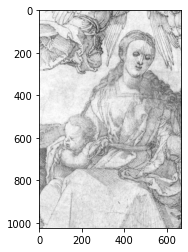

In [ ]:
idx = random.randrange(0,12700)
path = '../data/test/TEST_{0:05d}'.format(idx) + '.jpg'
print(path)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)
plt.imshow(image)

## Data Load

In [ ]:
def get_data(df, infer=False):
  if infer:
    return df['img_path'].values
    
  return df['img_path'].values, df['artist'].values

In [ ]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

## CustomDataset

In [ ]:
'''
Dataset : __init__, __getitem__는 필수적으로 __len__ 는 선택적으로 override 해야함
__getitem__ : 클래스를 인덱싱 할 때 반환을 어떻게 해줄 것인지 정의
__len__ : 클래스의 길이를 반환할 때 어떻게 해줄 것인지 정의

'''

from typing import Generic


class CustomDataset(Dataset):
  def __init__(self, img_paths, labels, transforms=None):
    self.img_paths = img_paths
    self.labels = labels
    self.transforms = transforms

  def __getitem__(self, index):
    img_path = self.img_paths[index]

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transforms is not None:
      image = self.transforms(image=image)['image']

    if self.labels is not None:
      label = self.labels[index]
      return image, label, img_path
    else:
      return image, img_path

  def __len__(self):
    return len(self.img_paths)
    

In [ ]:
# Albumentation Augmentation
# https://hoya012.github.io/blog/albumentation_tutorial/

train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.OneOf([A.RandomSizedCrop([50,CFG['IMG_SIZE']],CFG['IMG_SIZE'],CFG['IMG_SIZE'],p=0.8,w2h_ratio=0.5)],p=0.8),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.OneOf([A.RandomSizedCrop([50,CFG['IMG_SIZE']],CFG['IMG_SIZE'],CFG['IMG_SIZE'],p=0.8,w2h_ratio=0.5)],p=0.8),
                            #A.RandomCrop(50, 150,0.5),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            #A.OneOf([A.RandomSizedCrop([50,CFG['IMG_SIZE']],CFG['IMG_SIZE'],CFG['IMG_SIZE'],p=0.5,w2h_ratio=0.5)],p=0.5),
                            #A.RandomCrop(50, 150,0.5),
                            ToTensorV2()
                            ])

'''
A.HorizontalFlip(p=0.5),
A.HueSaturationValue(p=0.2),
A.ColorJitter(brightness=0.2,contrast=0.2, saturation=0.2, hue=0.2)d
A.ImageCompression(),
A.RandomResizedCrop(height=1300, width=1024, scale=(0.3, 1.0)),
A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
'''

"\nA.HorizontalFlip(p=0.5),\nA.HueSaturationValue(p=0.2),\nA.ColorJitter(brightness=0.2,contrast=0.2, saturation=0.2, hue=0.2)d\nA.ImageCompression(),\nA.RandomResizedCrop(height=1300, width=1024, scale=(0.3, 1.0)),\nA.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),\nA.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),\n"

In [ ]:
# Data Loader
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_img_paths, val_labels, val_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Define

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        #self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone = models.regnet_y_32gf(models.RegNet_Y_32GF_Weights.IMAGENET1K_V1)
        #self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.classifier = nn.Linear(1000, num_classes) # 왜 softmax를 잘 안쓸까?
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

## Train

In [ ]:
from traitlets.traitlets import validate

def train(model, optimizer, train_loader, test_loader, scheduler, device):
  es_count = 0
  # 모델을 device에 할당
  model.to(device)

  # Loss 정의
  criterion = nn.CrossEntropyLoss().to(device)

  # Scheduler에서 사용할 변수 선언
  best_score = 0
  best_model = None

  for epoch in range(1, CFG['EPOCHS'] + 1):
    # model을 train 모드로 전환
    model.train()

    # loss값을 넣을 리스트 생성
    train_loss = []

    # Epoch 진행
    for img, label, path in tqdm(iter(train_loader)):
      img, label = img.float().to(device), label.to(device)

      # optimizer 초기화
      optimizer.zero_grad()

      # pred값 
      model_pred = model(img)

      # 선언한 Loss에 pred값과 정답을 넣기 
      loss = criterion(model_pred, label)

      # backpropagation
      loss.backward()

      # optimizer
      optimizer.step()

      # loss값 추가
      train_loss.append(loss.item())

    # 최종 loss값 생성
    tr_loss = np.mean(train_loss)

    val_loss, val_score = validation(model, criterion, test_loader, device)

    print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')

    # Scheduler
    if scheduler is not None:
      scheduler.step()

    es_count += 1

    # val_score을 기준으로 best model 선정
    if best_score < val_score:
      best_model = model
      best_score = val_score
      es_count = 0

    if es_count > CFG['PATIENCE'] :
      print('endured enough')
      break


  return best_model

In [ ]:
# 이번 대회에서는 F1 score를 사용
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

In [ ]:
def validation(model, criterion, test_loader, device):

  # 모델을 평가용으로 전환 (dropout 등의 규제가 들어가지 않게 조절)
  model.eval()

  model_preds = []
  true_labels = []

  val_loss = []

  with torch.no_grad():
    for img, label,path in tqdm(iter(test_loader)):
      img, label = img.float().to(device), label.to(device)
      model_pred = model(img)
      loss = criterion(model_pred, label)
      val_loss.append(loss.item())

      model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
      true_labels += label.detach().cpu().numpy().tolist()

  val_f1 = competition_metric(true_labels, model_preds)
  return np.mean(val_loss), val_f1

In [ ]:
# Run

model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/regnet_y_32gf-4dee3f7a.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf-4dee3f7a.pth


  0%|          | 0.00/554M [00:00<?, ?B/s]

  0%|          | 0/74 [00:00<?, ?it/s]

RuntimeError: ignored

## Inference

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/test.csv')
test.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [ ]:
test['img_path'] = test['img_path'].apply(lambda x : '/content/drive/MyDrive/Colab Notebooks/Artist_classification/data' + x[1:] )

In [ ]:
# Test에는 artist 정보가 없으니 infer=True
test_img_paths = get_data(test, infer=True)

In [ ]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img,_ in tqdm(iter(test_loader)):
            img = img.float().to(device)
            
            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
    
    print('Done.')
    return model_preds

In [ ]:
preds = inference(infer_model, test_loader, device)
# 1시간

  0%|          | 0/198 [00:00<?, ?it/s]

Done.


In [ ]:
preds = le.inverse_transform(preds) # LabelEncoder로 변환 된 Label을 다시 화가이름으로 변환

## Submit

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Artist_classification/data/sample_submission.csv')
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Edgar Degas
2,TEST_00002,Edgar Degas
3,TEST_00003,Edgar Degas
4,TEST_00004,Edgar Degas


In [ ]:
submit['artist'] = preds
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Caravaggio
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Pablo Picasso


In [ ]:
submit.to_csv('submit.csv', index=False)